In [1]:
%matplotlib inline

# Edited version of PyTorch DCGAN tutorial for MNIST
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
Main edits: Edited the architecture and parameters to work for MNIST instead of CelebA but kept structure otherwise the same


DCGAN Tutorial
==============

**Author**: `Nathan Inkawhich <https://github.com/inkawhich>`__


In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Root directory for dataset
dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
#image_size = 64
image_size = 32

# Number of channels in the training images. For color images this is 3
#nc = 3
nc = 1 

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
#ngf = 64
ngf = 8

# Size of feature maps in discriminator
#ndf = 64
ndf = 8

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

Random Seed:  999


Data
----

We will use MNIST instead of CelebA as in the original tutorial

0it [00:00, ?it/s]

9920512it [00:00, 11036156.56it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 206851.80it/s]           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 4557841.36it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 56578.24it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


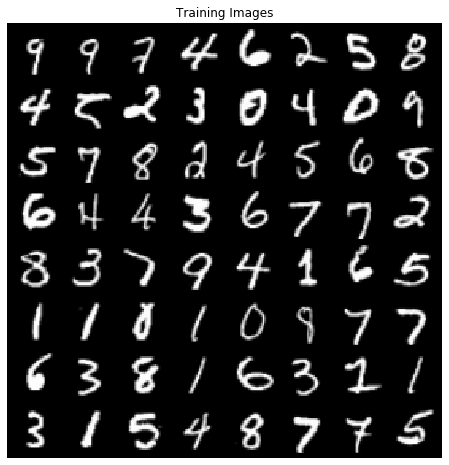

In [3]:
dataset = dset.MNIST(
    'data', train=True, download=True,
   transform=transforms.Compose([
       transforms.Resize(image_size), # Resize from 28 x 28 to 32 x 32 (so power of 2)
       transforms.CenterCrop(image_size),
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
   ])) 

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [16]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution, state size. nz x 1 x 1
            nn.ConvTranspose2d( nz, ngf * 4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True), # inplace ReLU
            # current state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # current state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # current state size. ngf x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            # current state size. nc x 32 x 32 
            nn.Tanh() # Produce number between 0 and 1 for pixel values
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


Discriminator
~~~~~~~~~~~~~

As mentioned, the discriminator, $D$, is a binary classification
network that takes an image as input and outputs a scalar probability
that the input image is real (as opposed to fake). Here, $D$ takes
a 3x64x64 input image, processes it through a series of Conv2d,
BatchNorm2d, and LeakyReLU layers, and outputs the final probability
through a Sigmoid activation function. This architecture can be extended
with more layers if necessary for the problem, but there is significance
to the use of the strided convolution, BatchNorm, and LeakyReLUs. The
DCGAN paper mentions it is a good practice to use strided convolution
rather than pooling to downsample because it lets the network learn its
own pooling function. Also batch norm and leaky relu functions promote
healthy gradient flow which is critical for the learning process of both
$G$ and $D$.




Discriminator Code



In [17]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32 
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8 
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            # state size. (ndf*4) x 1 x 1
            nn.Sigmoid()  # Produce probability
        )

    def forward(self, input):
        return self.main(input)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Loss Functions and Optimizers
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

With $D$ and $G$ setup, we can specify how they learn
through the loss functions and optimizers. We will use the Binary Cross
Entropy loss
(`BCELoss <https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss>`__)
function which is defined in PyTorch as:

\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}

Notice how this function provides the calculation of both log components
in the objective function (i.e. $log(D(x))$ and
$log(1-D(G(z)))$). We can specify what part of the BCE equation to
use with the $y$ input. This is accomplished in the training loop
which is coming up soon, but it is important to understand how we can
choose which component we wish to calculate just by changing $y$
(i.e. GT labels).

Next, we define our real label as 1 and the fake label as 0. These
labels will be used when calculating the losses of $D$ and
$G$, and this is also the convention used in the original GAN
paper. Finally, we set up two separate optimizers, one for $D$ and
one for $G$. As specified in the DCGAN paper, both are Adam
optimizers with learning rate 0.0002 and Beta1 = 0.5. For keeping track
of the generator’s learning progression, we will generate a fixed batch
of latent vectors that are drawn from a Gaussian distribution
(i.e. fixed_noise) . In the training loop, we will periodically input
this fixed_noise into $G$, and over the iterations we will see
images form out of the noise.




In [9]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Training
~~~~~~~~

Finally, now that we have all of the parts of the GAN framework defined,
we can train it. Be mindful that training GANs is somewhat of an art
form, as incorrect hyperparameter settings lead to mode collapse with
little explanation of what went wrong. Here, we will closely follow
Algorithm 1 from Goodfellow’s paper, while abiding by some of the best
practices shown in `ganhacks <https://github.com/soumith/ganhacks>`__.
Namely, we will “construct different mini-batches for real and fake”
images, and also adjust G’s objective function to maximize
$logD(G(z))$. Training is split up into two main parts. Part 1
updates the Discriminator and Part 2 updates the Generator.

**Part 1 - Train the Discriminator**

Recall, the goal of training the discriminator is to maximize the
probability of correctly classifying a given input as real or fake. In
terms of Goodfellow, we wish to “update the discriminator by ascending
its stochastic gradient”. Practically, we want to maximize
$log(D(x)) + log(1-D(G(z)))$. Due to the separate mini-batch
suggestion from ganhacks, we will calculate this in two steps. First, we
will construct a batch of real samples from the training set, forward
pass through $D$, calculate the loss ($log(D(x))$), then
calculate the gradients in a backward pass. Secondly, we will construct
a batch of fake samples with the current generator, forward pass this
batch through $D$, calculate the loss ($log(1-D(G(z)))$),
and *accumulate* the gradients with a backward pass. Now, with the
gradients accumulated from both the all-real and all-fake batches, we
call a step of the Discriminator’s optimizer.

**Part 2 - Train the Generator**

As stated in the original paper, we want to train the Generator by
minimizing $log(1-D(G(z)))$ in an effort to generate better fakes.
As mentioned, this was shown by Goodfellow to not provide sufficient
gradients, especially early in the learning process. As a fix, we
instead wish to maximize $log(D(G(z)))$. In the code we accomplish
this by: classifying the Generator output from Part 1 with the
Discriminator, computing G’s loss *using real labels as GT*, computing
G’s gradients in a backward pass, and finally updating G’s parameters
with an optimizer step. It may seem counter-intuitive to use the real
labels as GT labels for the loss function, but this allows us to use the
$log(x)$ part of the BCELoss (rather than the $log(1-x)$
part) which is exactly what we want.

Finally, we will do some statistic reporting and at the end of each
epoch we will push our fixed_noise batch through the generator to
visually track the progress of G’s training. The training statistics
reported are:

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches ($log(D(x)) + log(D(G(z)))$).
-  **Loss_G** - generator loss calculated as $log(D(G(z)))$
-  **D(x)** - the average output (across the batch) of the discriminator
   for the all real batch. This should start close to 1 then
   theoretically converge to 0.5 when G gets better. Think about why
   this is.
-  **D(G(z))** - average discriminator outputs for the all fake batch.
   The first number is before D is updated and the second number is
   after D is updated. These numbers should start near 0 and converge to
   0.5 as G gets better. Think about why this is.

**Note:** This step might take a while, depending on how many epochs you
run and if you removed some data from the dataset.




In [10]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.2262	Loss_G: 0.7743	D(x): 0.5771	D(G(z)): 0.4852 / 0.4646
[0/5][50/469]	Loss_D: 0.5651	Loss_G: 1.4237	D(x): 0.8186	D(G(z)): 0.2998 / 0.2457
[0/5][100/469]	Loss_D: 0.2735	Loss_G: 2.5098	D(x): 0.8761	D(G(z)): 0.1257 / 0.0850
[0/5][150/469]	Loss_D: 0.1213	Loss_G: 3.0445	D(x): 0.9446	D(G(z)): 0.0590 / 0.0508
[0/5][200/469]	Loss_D: 0.0612	Loss_G: 3.3929	D(x): 0.9811	D(G(z)): 0.0410 / 0.0367
[0/5][250/469]	Loss_D: 0.0408	Loss_G: 3.8207	D(x): 0.9882	D(G(z)): 0.0278 / 0.0252
[0/5][300/469]	Loss_D: 0.0240	Loss_G: 4.1598	D(x): 0.9949	D(G(z)): 0.0187 / 0.0175
[0/5][350/469]	Loss_D: 0.0203	Loss_G: 4.3342	D(x): 0.9968	D(G(z)): 0.0169 / 0.0152
[0/5][400/469]	Loss_D: 0.0150	Loss_G: 4.6336	D(x): 0.9978	D(G(z)): 0.0127 / 0.0114
[0/5][450/469]	Loss_D: 0.0139	Loss_G: 4.8258	D(x): 0.9977	D(G(z)): 0.0115 / 0.0098
[1/5][0/469]	Loss_D: 0.0118	Loss_G: 4.9176	D(x): 0.9978	D(G(z)): 0.0096 / 0.0085
[1/5][50/469]	Loss_D: 0.0099	Loss_G: 5.0373	D(x): 0.9982	D(G(z)): 

Results
-------

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




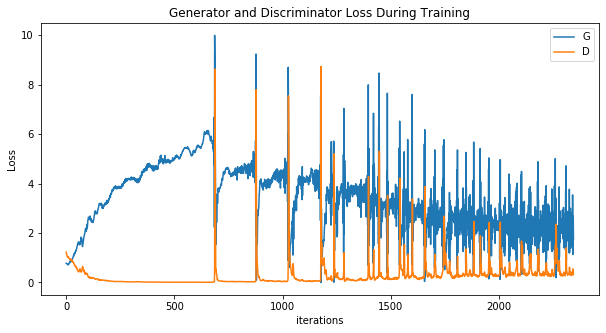

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




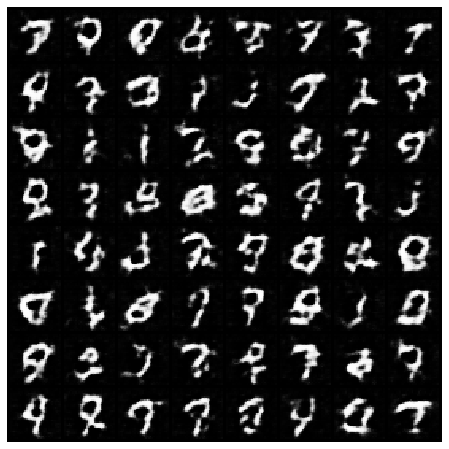

In [12]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




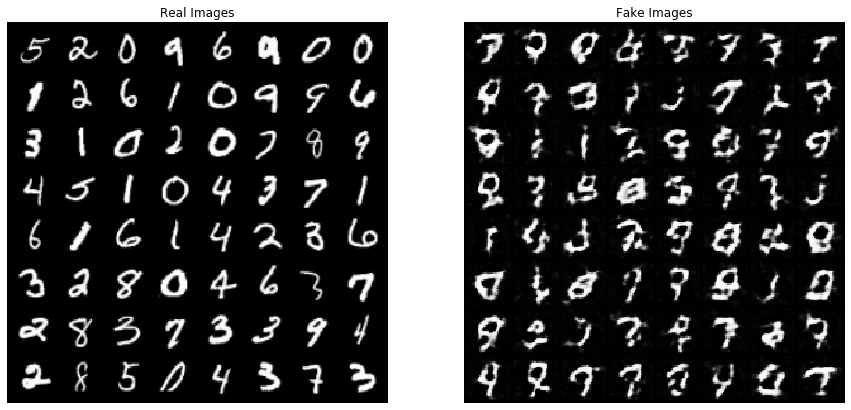

In [13]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

Where to Go Next
----------------

We have reached the end of our journey, but there are several places you
could go from here. You could:

-  Train for longer to see how good the results get
-  Modify this model to take a different dataset and possibly change the
   size of the images and the model architecture
-  Check out some other cool GAN projects
   `here <https://github.com/nashory/gans-awesome-applications>`__
-  Create GANs that generate
   `music <https://deepmind.com/blog/wavenet-generative-model-raw-audio/>`__


